<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Exploratory Data Analysis on a Natural Language Processing Task

---

Exploratory data analysis (EDA) is a crucial part of any data science project. EDA helps us discover interesting relationships in the data, detect outliers and errors, examine our own assumptions about the data, and prepare for modeling. During EDA we might discover that we need to clean our data more conscientiously, or that we have more missing data than we realized, or that there aren't many patterns in the data (indicating that modeling may be challenging.)

In this lab you'll bring in a natural language dataset and perform EDA. The dataset contains Facebook statuses taken from between 2009 and 2011 as well as personality test results associated with the users whose Facebook statuses are included.

This dataset uses results from the Big Five Personality Test, also referred to as the five-factor model, which measures a person's score on five dimensions of personality:
- **O**penness
- **C**onscientiousness
- **E**xtroversion
- **A**greeableness
- **N**euroticism

Notoriously, the political consulting group Cambridge Analytica claims to have predicted the personalities of Facebook users by using those users' data, with the goal of targeting them with political ads that would be particularly persuasive given their personality type. Cambridge Analytica claims to have considered 32 unique 'groups' in the following fashion:
- For each of the five OCEAN qualities, a user is categorized as either 'yes' or 'no'.
- This makes for 32 different potential combinations of qualities. ($2^5 = 32$).

Cambridge Analytica's methodology was then, roughly, the following:
- Gather a large amount of data from Facebook.
- Use this data to predict an individual's Big Five personality "grouping."
- Design political advertisements that would be particularly effective to that particular "grouping." (For example, are certain advertisements particularly effective toward people with specific personality traits?)

In this lab you will perform EDA to examine many relationships in the data.

Exploratory data analysis can be a non-linear process, and you're encouraged to explore questions that occur to you as you work through the notebook.

> **Content note**: This dataset contains real Facebook statuses scraped from 2009 to 2011, and some of the statuses contain language that is not safe for work, crude, or offensive. The full dataset is available as `mypersonality.csv`, and a sanitized version containing only statuses that passed an automated profanity check is available as `mypersonality_noprofanity.csv`. Please do not hesitate to use `mypersonality_noprofanity.csv` if you would prefer to. Please note that the automated profanity check is not foolproof. If you have any concerns about working with this dataset, please get in touch with your instructional team.

---

### External resources

These resources are not required reading but may be of use or interest.

- [**Python Graph Gallery**](https://python-graph-gallery.com/)
- [**Wikipedia page**](https://en.wikipedia.org/wiki/Big_Five_personality_traits) on the Big Five test
- [**A short (3-4 pages) academic paper**](./celli-al_wcpr13.pdf) using the `MyPersonality` dataset to model personality

---

In [54]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer

# This setting widens how many characters 
# pandas will display in a column
pd.options.display.max_colwidth = 400

# distplots from Seaborn are still awesome
import warnings
warnings.filterwarnings('ignore', category=UserWarning)

---

## Load data

In [55]:
df = pd.read_csv('data/mypersonality.csv')

# NOTICE! Do read the commented out code below...

# df = pd.read_csv('data/mypersonality_noprofanity.csv') 
# comment out above & 
# uncomment this to use mypersonality_noprofanity.csv if it 
# makes you more comfortable

df.drop(columns=['NETWORKSIZE', 'BETWEENNESS', 'NBETWEENNESS', 
                 'DENSITY', 'BROKERAGE', 'NBROKERAGE', 
                 'TRANSITIVITY'], inplace=True)
df.head(3)

,#AUTHID,STATUS,sEXT,sNEU,sAGR,sCON,sOPN,cEXT,cNEU,cAGR,cCON,cOPN,DATE
0,b7b7764cfa1c523e4e93ab2a79a946c4,likes the sound of thunder.,2.65,3.0,3.15,3.25,4.4,n,y,n,n,y,06/19/09 03:21 PM
1,b7b7764cfa1c523e4e93ab2a79a946c4,is so sleepy it's not even funny that's she can't get to sleep.,2.65,3.0,3.15,3.25,4.4,n,y,n,n,y,07/02/09 08:41 AM
2,b7b7764cfa1c523e4e93ab2a79a946c4,"is sore and wants the knot of muscles at the base of her neck to stop hurting. On the other hand, YAY I'M IN ILLINOIS! <3",2.65,3.0,3.15,3.25,4.4,n,y,n,n,y,06/15/09 01:15 PM


---

## EDA on Statuses

Before we even vectorize the text, we might look at the lengths and word counts in each Facebook status.

**Create a new column called `status_length` that contains the length of each status:**

In [56]:
df['status_length'] = df['STATUS'].apply(lambda x: len(x))    # Whitespaces are included

**Create a new column called `status_word_count` that contains the number of words in each status:**

Note: You can evaluate this based off of how many strings are separated by whitespaces; you're not required to check that each set of characters set apart by whitespaces is a word in the dictionary.

In [57]:
df['status_word_count'] = df['STATUS'].apply(lambda x: len(x.split()))

### Longest and shortest statuses

Looking at individual observations can help us get a sense of what the dataset contains.

**Show the five longest and five shortest statuses based off of `status_word_count`:**

In [58]:
df[['STATUS','status_word_count']].sort_values(by='status_word_count', ascending = False).head()

,STATUS,status_word_count
496,"Exact words when renewing DL: Me: Oh no, you can't take my license, It's my 25th b-day. How am I going to get into the bar? DMV: We gonna give you a new one over there Me: But, it won't have my picture and stuff on it. Dmv: Hold up, we can take a picture of your picture and put it on a license i think. (yelling at co-worker to see if this can be done) Yup! Me: So, I can go to the bar?! Dmv: ...",89
6989,"If I wear makeup, I'm fake. If I like to get dressed up, I'm a Tart. If I say what i think, I'm a bitch. If I cry sometimes, I'm a drama queen. If I have guy friends, I'm a slut. If I stand up for myself, I'm mouthy. Seems like you can't do anything now a days without being labeled.. So what, go ahead and label me, see if i give a shit. Repost this if your proud of who you are! x x",85
5208,"can't believe it. I got the new Wii Fit Plus game, it has a lot of fun new games and features. However, after not using the wii fit for a few months we decided to do the fitness test stuff again. Me(since last time): +2.9 lbs, still a healthy weight and BMI, wii age 54. *PROPNAME*: -8.6lbs, reccommends a healthy weight of gaining 6lbs, wii age 32. On the positive side, I have lost 5 of the 8 l...",84
7976,"""I said he's a fairy I do suppose//flyin thru the air in pantyhose//he may be very sexy or even cute//but he looks like a sucka in a blue and red suit//I said you need a man who's got finesse//& his whole name across his chest//he may be able to fly all thru the night//but can he rock a party til the early light//he can't satisfy you with his little worm//but I can bust you out w my Super sper...",83
5680,"I always make it a rule to let the other fellow fire first. If a man wants to fight, I argue the question with him and try to show him how foolish it would be. If he can't be dissuaded, why then the fun begins but I always let him have first crack. Then when I fire, you see, I have the verdict of self-defence on my side. I know that he is pretty certain in his hurry, to miss. I never do.",83


In [59]:
df[['STATUS','status_word_count']].sort_values(by='status_word_count', ascending = True).head()

,STATUS,status_word_count
8178,157,1
4170,"wed,.",1
2016,HOUSE!,1
956,Err:509,1
4177,confused,1


## What's the distribution of post lengths?

Use visuals to show the distributions of post lengths. Show both the distribution of word counts and the distribution of lengths based off character.

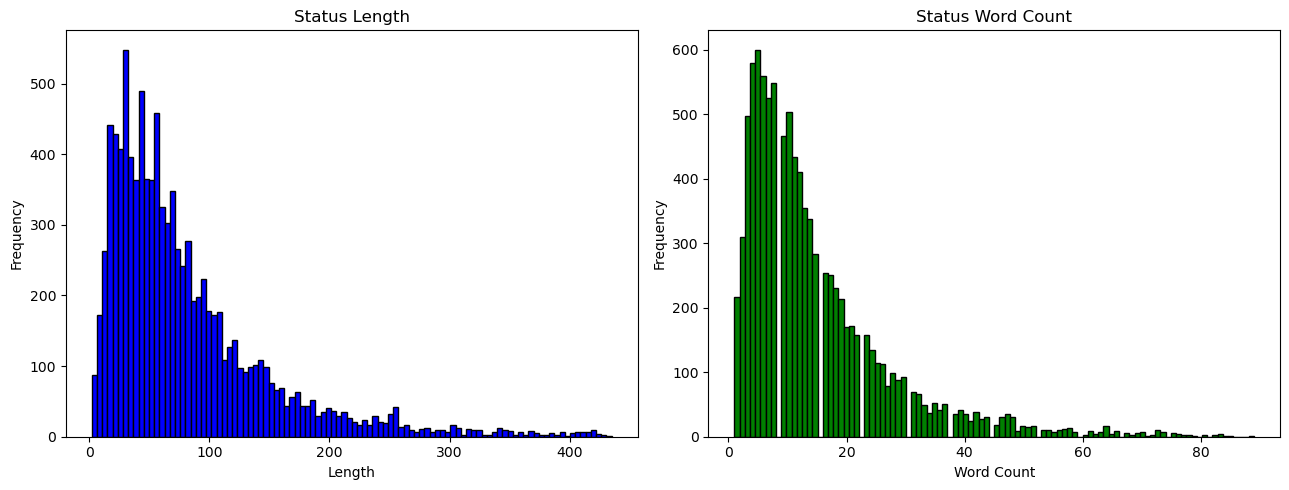

In [60]:
fig, ax = plt.subplots(1, 2, figsize = (13, 5))

# Histogram of status length
ax[0].hist(df['status_length'], bins = 100, color = 'blue', edgecolor = 'black')
ax[0].set_title('Status Length')
ax[0].set_xlabel('Length')
ax[0].set_ylabel('Frequency')

# Histogram of status word count
ax[1].hist(df['status_word_count'], bins = 100, color = 'green', edgecolor = 'black')
ax[1].set_title('Status Word Count')
ax[1].set_xlabel('Word Count')
ax[1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

---

## EDA of Personality Scores

There are two sets of personality columns in the dataset: class and score. According to the attached paper, scores have been converted to categories based on whether a score for a user fell above or below the median.

### Plot the distributions of personality scores for all five score columns:

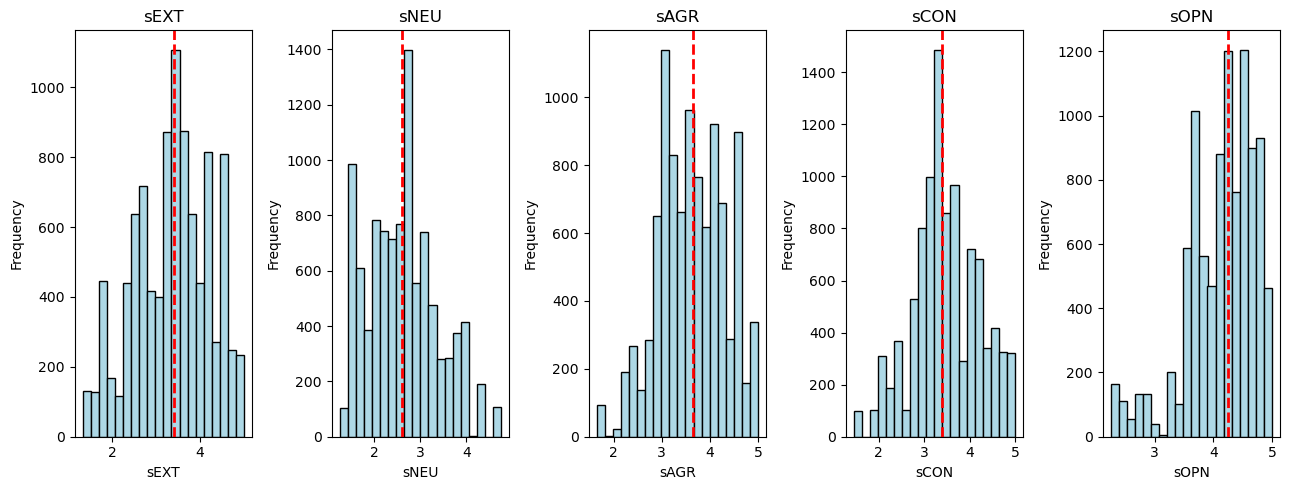

In [61]:
fig, ax = plt.subplots(1, 5, figsize = (13, 5))

column_to_plot = ['sEXT','sNEU','sAGR','sCON','sOPN']
column_median = [df[col].median() for col in column_to_plot]


for i in range(len(column_to_plot)):
    ax[i].hist(df[column_to_plot[i]], bins = 20, color = 'lightblue', edgecolor = 'black')
    ax[i].set_title(column_to_plot[i])
    ax[i].set_xlabel(column_to_plot[i])
    ax[i].set_ylabel('Frequency')   
    ax[i].axvline(column_median[i], color = 'red', linestyle = 'dashed', linewidth = 2)   # Show median vertical line
plt.tight_layout()
plt.show()

---

### How many unique users exist in the dataset?

This dataset has redacted original poster names, but each user is given an `#AUTHID`. How many unique users are there, and how many posts per user do we have?

In [62]:
# len(df['#AUTHID']) = 9916
df['#AUTHID'].nunique()

250

## EDA on unique users

Because we have many posts per user for most users, doing EDA on the personality score columns might be misleading. If we have 200 Facebook statuses from one very high-conscientiousness user, a bar chart of how many `'cCON'` statuses are associated with `'y'` might be misleading. We'll have to be careful about labeling and titling any visualizations we make off of the dataset.

**Create a new dataframe called `unique_users` that only contains the `#AUTHID`, personality score, and personality category columns:**

If you do this correctly, it should have 250 rows and 11 columns.

(Hint: You can use the pandas [**drop_duplicates()**](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.drop_duplicates.html) method to make this easier. The only column you want to consider when deciding if a user is duplicated is the `#AUTHID` column.)

In [63]:
column_to_keep = ['#AUTHID','sEXT','sNEU','sAGR','sCON','sOPN','cEXT','cNEU','cAGR','cCON','cOPN','status_length','status_word_count']
unique_users = df[column_to_keep].drop_duplicates(subset = ['#AUTHID'], keep = 'first')  # Keep only first occurence

In [64]:
unique_users.shape   # 13 because including 'status_length','status_word_count'

(250, 13)

**Plot the distribution of personality scores for `unique_users`:**

Do the distributions look different? Here, each individual user will only be represented once.

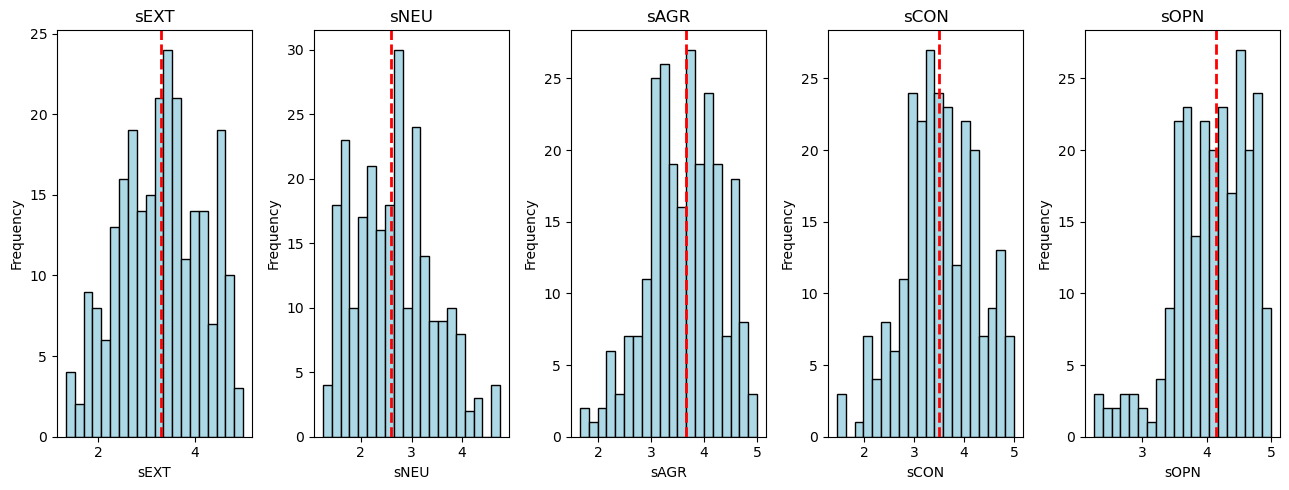

In [65]:
fig, ax = plt.subplots(1, 5, figsize = (13, 5))

column_to_plot = ['sEXT','sNEU','sAGR','sCON','sOPN']
column_median = [unique_users[col].median() for col in column_to_plot]


for i in range(len(column_to_plot)):
    ax[i].hist(unique_users[column_to_plot[i]], bins = 20, color = 'lightblue', edgecolor = 'black')
    ax[i].set_title(column_to_plot[i])
    ax[i].set_xlabel(column_to_plot[i])
    ax[i].set_ylabel('Frequency')   
    ax[i].axvline(column_median[i], color = 'red', linestyle = 'dashed', linewidth = 2)   # Show median vertical line
plt.tight_layout()
plt.show()

In [66]:
# Slightly different for the original df, but the medians move little bit

**Use the `.describe()` method on `unique_users`:**

In [67]:
unique_users.describe()

,sEXT,sNEU,sAGR,sCON,sOPN,status_length,status_word_count
count,250.000000,250.000000,250.000000,250.000000,250.00000,250.000000,250.000000
mean,3.292120,2.627240,3.600320,3.522920,4.07856,74.160000,13.528000
std,0.861368,0.776835,0.670758,0.740211,0.57506,66.660309,12.191956
min,1.330000,1.250000,1.650000,1.450000,2.25000,3.000000,1.000000
25%,2.662500,2.000000,3.150000,3.000000,3.75000,30.250000,5.000000
50%,3.300000,2.590000,3.660000,3.500000,4.15000,54.500000,10.000000
75%,4.000000,3.150000,4.100000,4.050000,4.50000,89.750000,17.000000
max,5.000000,4.750000,5.000000,5.000000,5.00000,415.000000,83.000000


### Plots vs. Tables

Consider what different information is easily conveyed by the plots of scores, versus the table with summary statistics. Explain when you might present a distribution versus when you might present a table of summary statistics.

In [68]:
# When to show plots, the plots must be easy to see the skewness for conveying the distributions to the audience
# If not, show table for clearly values

#### Other visualizations:

Create at least 2 additional visualizations related to the `unique_users` dataframe.

You might consider:
- Bar charts of users per category per trait
- Seaborn correlation heatmap
- Seaborn pairplot

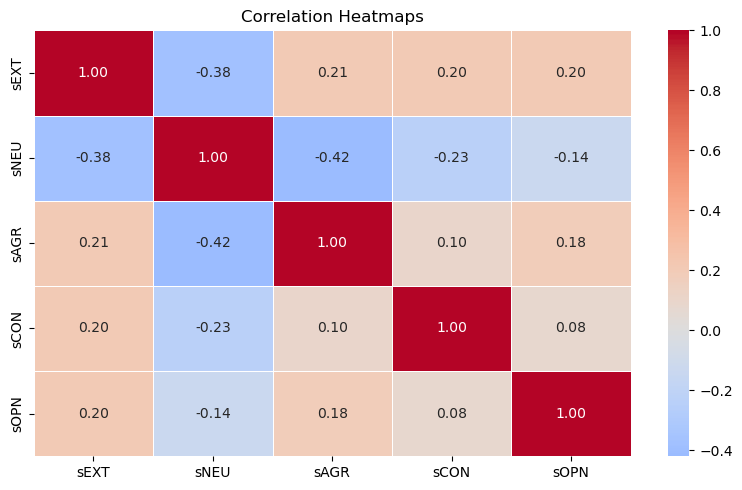

In [69]:
correlation_matrix = unique_users[column_to_plot].corr()

# Create the heatmap
plt.figure(figsize=(8, 5))
sns.heatmap(correlation_matrix, annot = True, cmap = 'coolwarm', fmt ='.2f', linewidths = 0.5, center = 0)
plt.title('Correlation Heatmaps')
plt.tight_layout()
plt.show();

<Figure size 800x500 with 0 Axes>

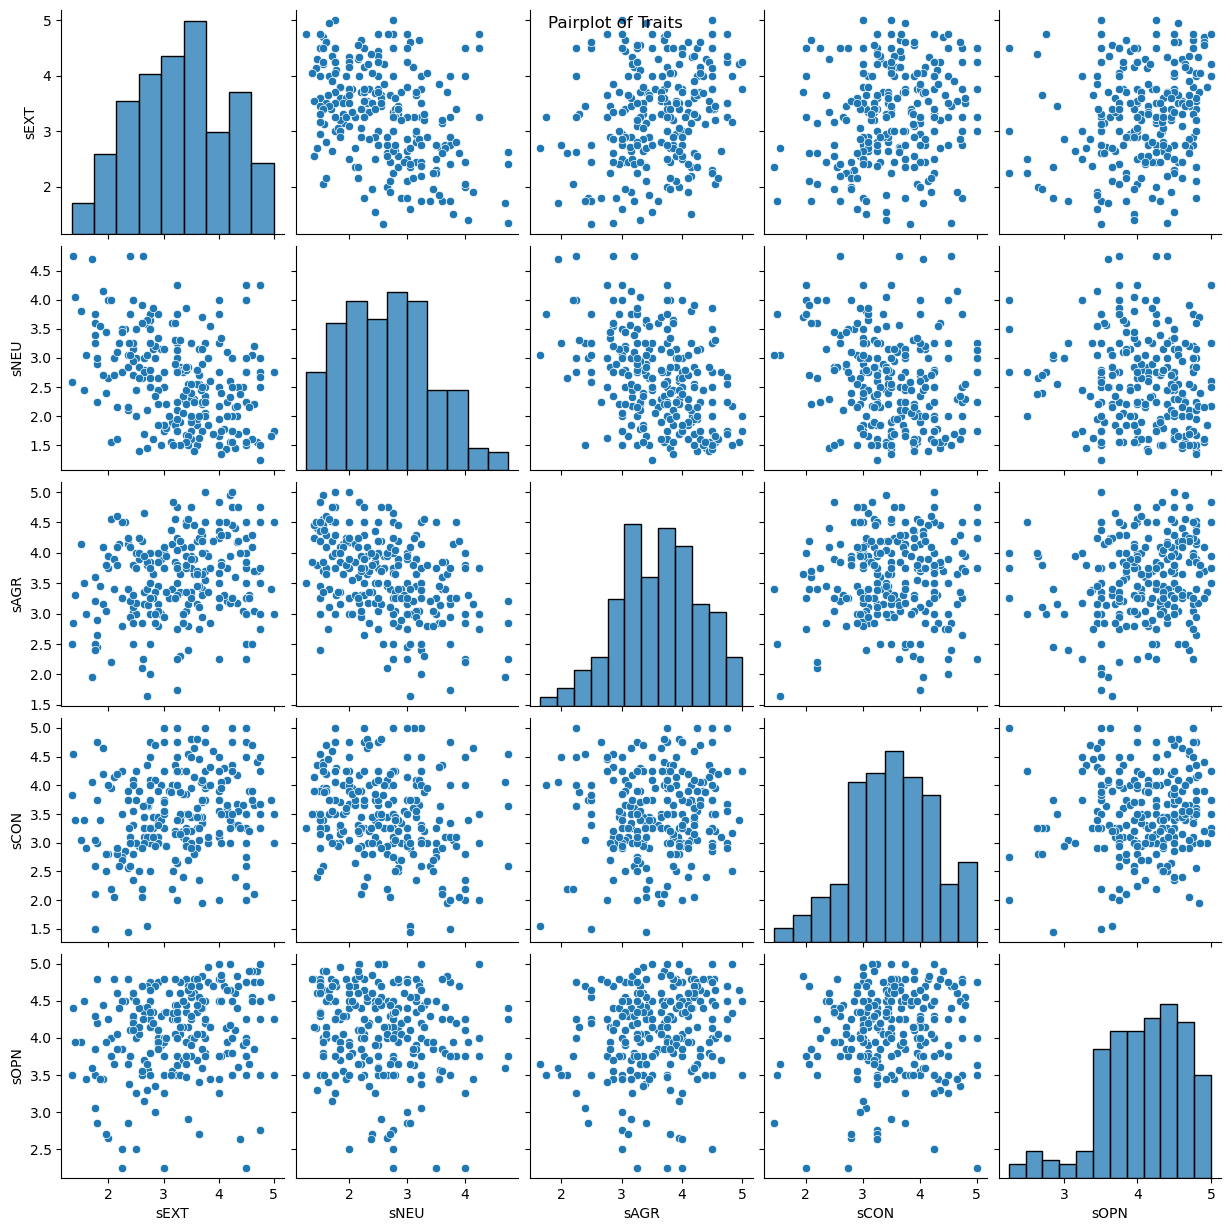

In [70]:
# Create the pairplot
plt.figure(figsize=(8, 5))
sns.pairplot(unique_users[column_to_plot])
plt.suptitle('Pairplot of Traits')
plt.show();

---

## Exploring status length and word count based on personality

**Using `groupby()`, find the mean status length and status word count for posts by users in the high and low categories of each of the Big 5 traits.**

You'll need to use `groupby()` five separate times for this.

In [71]:
unique_users[['cEXT','status_length', 'status_word_count']].groupby('cEXT').mean()

,status_length,status_word_count
cEXT,,
n,75.116883,13.571429
y,72.625000,13.458333


In [72]:
unique_users[['cNEU','status_length', 'status_word_count']].groupby('cNEU').mean()

,status_length,status_word_count
cNEU,,
n,75.079470,13.549669
y,72.757576,13.494949


In [73]:
unique_users[['cAGR','status_length', 'status_word_count']].groupby('cAGR').mean()

,status_length,status_word_count
cAGR,,
n,77.163793,14.120690
y,71.559701,13.014925


In [74]:
unique_users[['cCON','status_length', 'status_word_count']].groupby('cCON').mean()

,status_length,status_word_count
cCON,,
n,78.508333,14.500000
y,70.146154,12.630769


In [75]:
unique_users[['cOPN','status_length', 'status_word_count']].groupby('cOPN').mean()

,status_length,status_word_count
cOPN,,
n,72.283784,12.918919
y,74.948864,13.784091


**Choose one of the personality category columns (i.e. `cOPN`, `cCON`, `cEXT`, `cAGR`, or `cNEU`.) Use `sns.distplot()` to visualize the distribution of status word counts for posts by users who score both high (`y`) and low (`n`) in that personality category:**

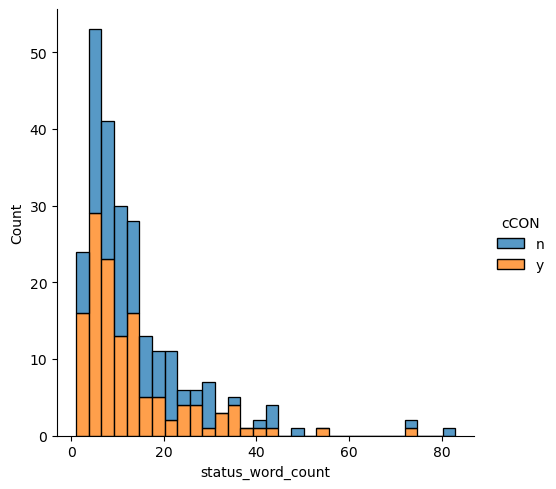

In [76]:
sns.displot(unique_users, x = 'status_word_count', bins = 30, hue = 'cCON', multiple = 'stack')
plt.show()

---

## EDA on Word Counts

### Vectorize the text

In order to perform EDA on word count data, we'll need to count vectorize.

Create a dataframe that contains the count-vectorized text for each Facebook status in the dataset.

To do this, you might follow these steps:
- Instantiate a `CountVectorizer` object
- Fit the count vectorizer on the Facebook statuses
- Store the transformed data
- Convert to a dataframe and store
    - Don't forget that the transformed data will need to be 'densified'. The `toarray()` or `todense()` methods will allow this.
    - Don't forget that the `get_feature_names_out()` method on a fitted `CountVectorizer` object will bring you back the words learned from the dataset, which you can set as the `columns` argument when creating the dataframe.
    
It's up to you whether or not to keep stopwords in the dataset.

In [77]:
# Instantiate CountVectorizer, remove stopwords
vectorizer = CountVectorizer(stop_words = 'english')

# Fit 
X = vectorizer.fit_transform(df['STATUS'])

# Make Dense Array
X_dense = X.todense() 

# get_feature_names_out to make data frame
df_x = pd.DataFrame(X_dense, columns=vectorizer.get_feature_names_out())

### Show the 15 most common words

In [78]:
# Sum frequencies by column
word_frequencies = df_x.sum(axis = 0)

# Print top 15
print(word_frequencies.sort_values(ascending = False).head(15))

propname    1309
just         717
day          534
like         506
time         424
going        414
today        402
new          386
work         369
good         354
got          314
night        312
love         292
tomorrow     277
know         276
dtype: int64


### Show the 15 frequency of the most common words as a bar chart

**Hint**: You can do this in one line of code. [This webpage](https://dfrieds.com/data-visualizations/bar-plot-python-pandas.html) has an example.

<Axes: title={'center': 'Top 15 Most Common Words'}>

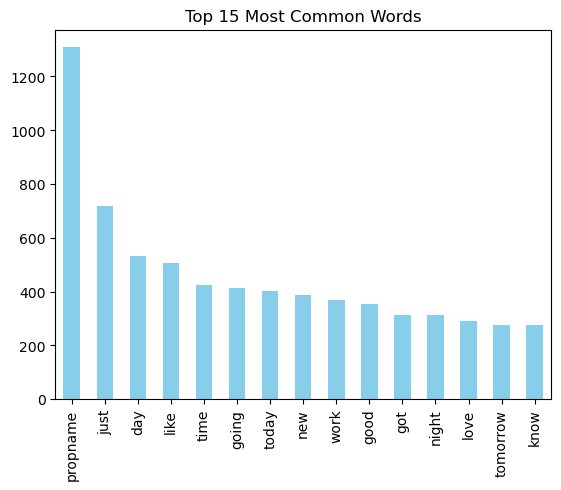

In [79]:
word_frequencies.sort_values(ascending = False).head(15).plot(kind ='bar', color = 'skyblue', title = 'Top 15 Most Common Words')

### Investigating `propname`

The word `propname` shows up frequently in this dataset. Show the first 10 statuses in the dataset that contain `propname`:

In [80]:
df[df['STATUS'].str.contains('propname', case = False)]['STATUS'].head(10)

6                                                                                                                                                                                                                                                         saw a nun zombie, and liked it. Also, *PROPNAME* + Tentacle!Man + Psychic Powers = GREAT Party.
18                                                                                                                                                                                                                                                                                                         is tired. *PROPNAME*, let me go to sleep pl0x.
69                                                                                                                                                                                                              has a fair idea of how to manage the 2.5 kids cliche... She just needs a very strong gentleman named

**Provide a short explanation of what you believe `propname` to be:**

In [81]:
# I believe it is the name of person the poster tagged

## Most common words based on personality category

In order to do more targeted EDA, we'll need to be able to reference not only the dataframe of vectorized statuses, but also the personality scores from the original dataframe.

**Create a new dataframe called `text_and_scores` that concatenates the count-vectorized statuses side-by-side with the original personality category columns:**

In [82]:
text_and_scores = pd.concat([df[['cEXT', 'cNEU', 'cAGR', 'cCON', 'cOPN']], df_x], axis=1)
text_and_scores

,cEXT,cNEU,cAGR,cCON,cOPN,00,000,000ft,00am,00pm,...,équipe,étais,était,étant,état,été,être,østersund,últimas,últimos
0,n,y,n,n,y,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,n,y,n,n,y,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,n,y,n,n,y,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,n,y,n,n,y,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,n,y,n,n,y,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9911,n,n,y,n,y,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9912,y,y,y,y,y,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9913,y,y,y,y,y,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9914,n,y,n,n,y,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


**Show the 25 most common words for statuses from high-cAGR users:**

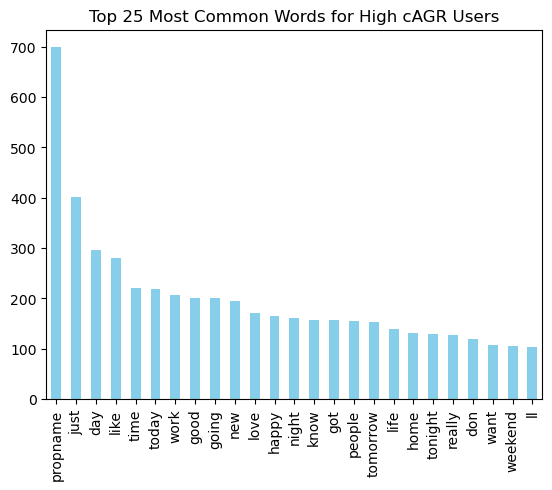

In [83]:
# Filter
high_cagr_users = text_and_scores[text_and_scores['cAGR'] == 'y']
# Sum by column (ignoring non-word columns)
word_frequencies_high_cagr = high_cagr_users.drop(columns = ['cEXT', 'cNEU', 'cCON', 'cOPN', 'cAGR']).sum(axis=0)
# Top 25
top_25_words_high_cagr = word_frequencies_high_cagr.sort_values(ascending = False).head(25)
# Plot
top_25_words_high_cagr.plot(kind = 'bar', color = 'skyblue', title = 'Top 25 Most Common Words for High cAGR Users');

**Show the 25 most common words for statuses from low-cAGR users:**

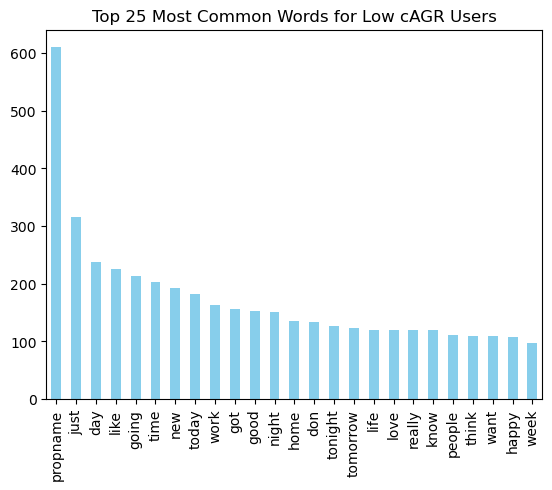

In [84]:
# Filter
low_cagr_users = text_and_scores[text_and_scores['cAGR'] == 'n']
# Sum by column (ignoring non-word columns)
word_frequencies_low_cagr = low_cagr_users.drop(columns = ['cEXT', 'cNEU', 'cCON', 'cOPN', 'cAGR']).sum(axis=0)
# Top 25
top_25_words_low_cagr = word_frequencies_low_cagr.sort_values(ascending = False).head(25)
# Plot
top_25_words_low_cagr.plot(kind = 'bar', color = 'skyblue', title = 'Top 25 Most Common Words for Low cAGR Users');

### Most common bigrams:

Find the 10 most common [**bigrams**](https://en.wikipedia.org/wiki/Bigram) in the dataset.

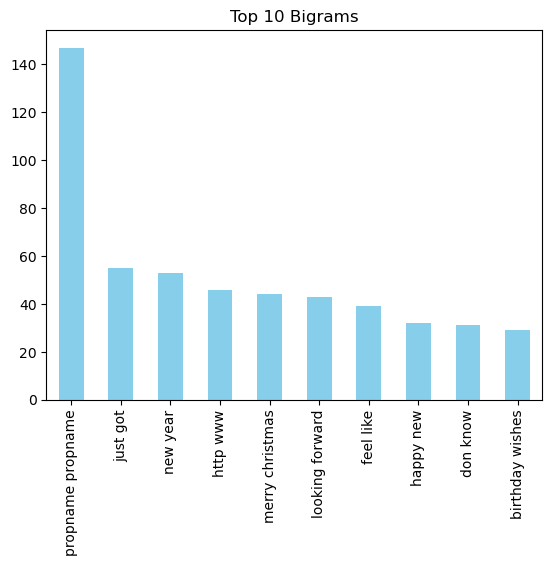

In [85]:
# Instantiate CountVectorizer, remove stopwords, only bigram
vectorizer = CountVectorizer(stop_words = 'english', ngram_range = (2,2))

# Fit 
X = vectorizer.fit_transform(df['STATUS'])

# Make Dense Array
X_dense = X.todense() 

# get_feature_names_out to make data frame
df_x = pd.DataFrame(X_dense, columns=vectorizer.get_feature_names_out())

# sum bigrams
bigrams = df_x.sum(axis=0)
# Top 10
top_bigrams = bigrams.sort_values(ascending = False).head(10)
# Plot
top_bigrams.plot(kind = 'bar', color = 'skyblue', title = 'Top 10 Bigrams');

### Most common trigrams:

Find the 10 most common [**trigrams**](https://en.wikipedia.org/wiki/Trigram) in the dataset.

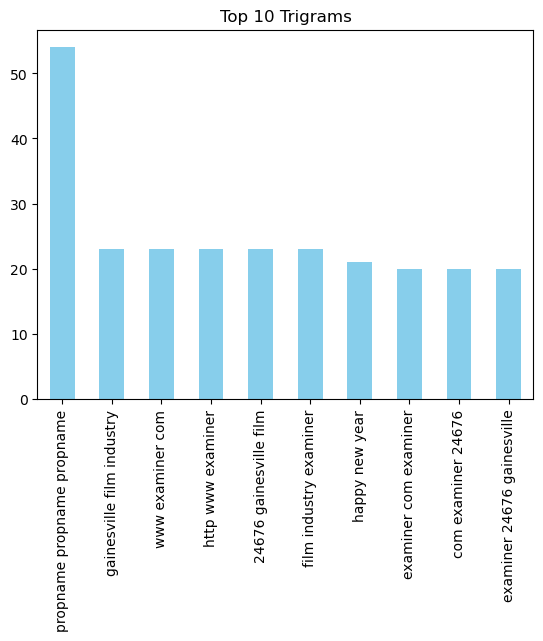

In [86]:
# Instantiate CountVectorizer, remove stopwords, only trigram
vectorizer = CountVectorizer(stop_words = 'english', ngram_range = (3,3))

# Fit 
X = vectorizer.fit_transform(df['STATUS'])

# Make Dense Array
X_dense = X.todense() 

# get_feature_names_out to make data frame
df_x = pd.DataFrame(X_dense, columns=vectorizer.get_feature_names_out())

# sum bigrams
trigrams = df_x.sum(axis=0)
# Top 10
top_trigrams = trigrams.sort_values(ascending = False).head(10)
# Plot
top_trigrams.plot(kind = 'bar', color = 'skyblue', title = 'Top 10 Trigrams');

---

## Choose your own adventure

By now you've looked at a lot of visualizations and frequency counts.

Come up with 2-3 questions about the data, and try to answer them using descriptive statistics (like counts, averages, etc.) or visualizations.

Some questions you might explore:
- Have numbers been redacted, or are phone numbers, house numbers, or zip codes anywhere in the dataset?
- `PROPNAME` has been used to redact personal names. Given that this data was scraped between 2009 and 2011, investigate if any public figures or famous people show up in the dataset, or their names have been redacted as well.
- Is count of uppercase letters vs. lowercase letters per status related to any personality category or personality score?
- Is _average_ word count per status related to any personality category or personality metric?
- Is punctuation use related to personality?

Or, of course, come up with your own questions to investigate!

The focus here is on "explore" -- you might not find anything of particular interest, but don't let that discourage you.

In [87]:
# Q: Do people with agreeableness post longer statuses than those without agreeableness?
# A: Although both groups use approximately the same word count, 
# people with agreeableness tend to use shorter words (mean length 71.5 versus 77).
unique_users[['cAGR','status_length', 'status_word_count']].groupby('cAGR').describe().T

cAGR                              n           y
status_length     count  116.000000  134.000000
                  mean    77.163793   71.559701
                  std     68.824913   64.874837
                  min      5.000000    3.000000
                  25%     28.750000   31.500000
                  50%     56.500000   54.000000
                  75%    106.000000   84.750000
                  max    412.000000  415.000000
status_word_count count  116.000000  134.000000
                  mean    14.120690   13.014925
                  std     12.654029   11.800972
                  min      1.000000    1.000000
                  25%      5.000000    6.000000
                  50%     10.000000   10.000000
                  75%     19.250000   15.750000
                  max     73.000000   83.000000

In [88]:
# Q: People without agreeableness tend to use longer words. What personality trait do they have?
# A: People without agreeableness tend to be introverted (cEXT = n) and open to experience (cOPN = y).

ext_counts = unique_users[unique_users['cAGR'] == 'n'][['cEXT']].value_counts(normalize=True).mul(100).round(1).rename('cEXT (%)')
neu_counts = unique_users[unique_users['cAGR'] == 'n'][['cNEU']].value_counts(normalize=True).mul(100).round(1).rename('cNEU (%)')
con_counts = unique_users[unique_users['cAGR'] == 'n'][['cCON']].value_counts(normalize=True).mul(100).round(1).rename('cCON (%)')
opn_counts = unique_users[unique_users['cAGR'] == 'n'][['cOPN']].value_counts(normalize=True).mul(100).round(1).rename('cOPN (%)')

result_table = pd.concat([ext_counts, neu_counts, con_counts, opn_counts], axis=1)
print(result_table)

   cEXT (%)  cNEU (%)  cCON (%)  cOPN (%)
n      66.4      44.0      52.6      39.7
y      33.6      56.0      47.4      60.3


---

## Exploratory vs. Explanatory Data Analysis 

> **Exploratory analysis** is what you do to get familiar with the data. You may start out with a hypothesis or question, or you may just really be delving into the data to determine what might be interesting about it. Exploratory analysis is the process of turning over 100 rocks to find perhaps 1 or 2 precious gemstones.
>
> **Explanatory analysis** is what happens when you have something specific you want to show an audience - probably about those 1 or 2 precious gemstones. In my blogging and writing, I tend to focus mostly on this latter piece, explanatory analysis, when you've already gone through the exploratory analysis and from this have determined something specific you want to communicate to a given audience: in other words, when you want to tell a story with data.

- Cole Nussbaumer Knaflic, [**exploratory vs. explanatory analysis**](http://www.storytellingwithdata.com/blog/2014/04/exploratory-vs-explanatory-analysis)

### Choose one visual to explain:

Now that you've performed an exploratory data analysis, choose a visual (or 1-3 related visuals) to frame as **_explanatory_**. This can be a visual you created above, or you can create a new visual. For this visual, make sure the visuals are formatted clearly, and provide a one to two paragraph explanation/interpretation of the visual.